In [1]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

import tensorflow as tf

# import random

# from copy import deepcopy

import pandas as pd
import numpy as np
import h5py

# import keras

from matplotlib import pyplot as plt

# import json

# import notebooks_utils.analysis as utils
from notebooks_utils import visuals

# from IPython.display import display

import project.download_content as content
from project.utils import data

# METAPATH = os.path.join(content.DATAPATH, 'METADATA')


# from keras.applications import VGG19, VGG16
from keras.preprocessing import image
# from keras.applications.vgg19 import preprocess_input as preprocess_19
# from keras.applications.vgg16 import preprocess_input as preprocess_16
# from keras.models import Model

# from keras import backend as K
# from keras import layers
from keras.optimizers import Adam, SGD

# import swifter

from project.model.ssd_model_300 import ssd_model_300
from project.model.ssd_model_624 import ssd_model_624
from project.model.ssd_model_624_vgg_19 import ssd_model_624_vgg_19
from project.model.loss import SSDloss
# from project.model.iou import iou
# from project.model.smooth_l1 import smooth_l1

# from project.utils import data

Using TensorFlow backend.


## loading boat dataset

In [2]:
filepath = os.path.join(content.DATAPATH, "MODEL", "part_data_300_vgg.h5")

train = pd.read_hdf(filepath, 'X', mode='r')

with h5py.File(filepath, 'r') as f:
    target = f['y'][:]

In [3]:
target.shape

(38122, 8732, 8)

boat            [False]
land_vehicle     [True]
skyscraper      [False]
Name: 2003, dtype: object

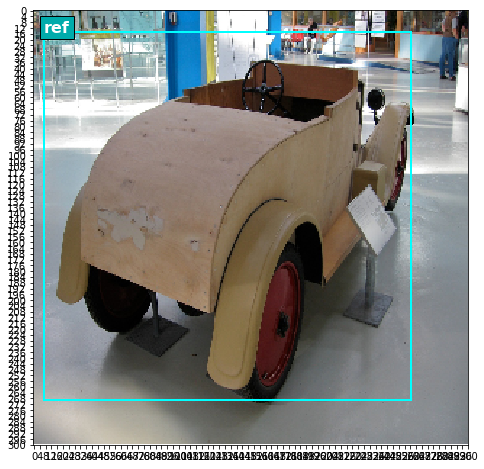

In [4]:
sample = train.iloc[2003]

display(sample[-3:])
img = image.load_img(sample.Path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# plt.grid()
plt.xticks(range(0, 301, int(300/75)))
plt.yticks(range(0, 301, int(300/75)))

visuals.draw_many_bboxes(img,
                         np.array([sample.cx, sample.cy, sample.w, sample.h]).T,
                         label='ref');

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [5]:
model = ssd_model_300()

# sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# ssd_loss = SSDloss()
# model.compile(optimizer=sgd, loss=ssd_loss.loss)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Training

In [6]:
standard_bboxes = data.StandardBoudingBoxes(feature_map_sizes=[38, 19, 10, 5, 3, 1],
                                            ratios_per_layer=[[1, 1/2, 2], 
                                                              [1, 1/2, 1/3, 2, 3],
                                                              [1, 1/2, 1/3, 2, 3],
                                                              [1, 1/2, 1/3, 2, 3],
                                                              [1, 1/2, 2],
                                                              [1, 1/2, 2]])

standard_bboxes.references

,cx,cy,w,h
0,0.013158,0.013158,0.005263,0.005263
1,0.013158,0.013158,0.003722,0.007443
2,0.013158,0.013158,0.007443,0.003722
3,0.013158,0.013158,0.006862,0.006862
4,0.013158,0.039474,0.005263,0.005263
...,...,...,...,...
8727,0.833333,0.833333,0.275681,0.275681
8728,0.500000,0.500000,0.900000,0.900000
8729,0.500000,0.500000,0.636396,1.272792
8730,0.500000,0.500000,1.272792,0.636396


In [8]:
model.load_weights(content.DATAPATH + '/weights300vgg16.h5')

In [10]:
train.loc[131]

ImageID                                 360fbcecdf089b17
Path             data/TRAIN/train_3/360fbcecdf089b17.jpg
cx                                           [0.1928125]
cy                                           [0.4792165]
w                                             [0.215625]
h                                             [0.331735]
bbox_ref                            [[8696, 8697, 8699]]
LabelSemantic                               [skyscraper]
boat                                             [False]
land_vehicle                                     [False]
skyscraper                                        [True]
Name: 131, dtype: object

In [11]:
target[131, 8696]

array([0.    , 0.    , 0.    , 1.    , 0.1929, 0.4792, 0.2156, 0.3318],
      dtype=float16)

ImageID                                 360fbcecdf089b17
Path             data/TRAIN/train_3/360fbcecdf089b17.jpg
cx                                           [0.1928125]
cy                                           [0.4792165]
w                                             [0.215625]
h                                             [0.331735]
bbox_ref                            [[8696, 8697, 8699]]
LabelSemantic                               [skyscraper]
boat                                             [False]
land_vehicle                                     [False]
skyscraper                                        [True]
Name: 131, dtype: object

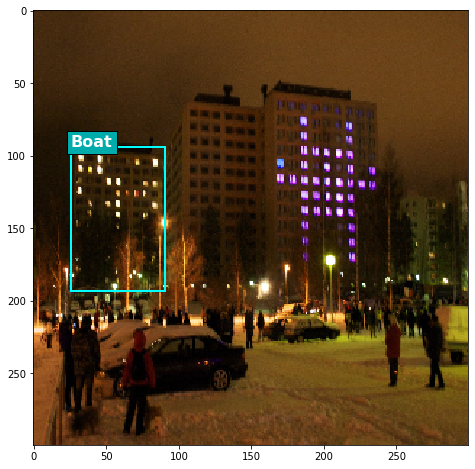

In [12]:
img_path = train.loc[131]

display(img_path)

img = image.load_img(img_path.Path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# # plt.grid(color='red')
# plt.xticks(range(0, 301, int(300/5)))
# plt.yticks(range(0, 301, int(300/5)))

visuals.draw_many_bboxes(img,
                         np.array([img_path.cx, img_path.cy, img_path.w, img_path.h]).T,
                         label='Boat');

In [13]:
pred = model.predict(np.expand_dims(image.img_to_array(img), axis=0))[0]

m_value = 0 
best_i = 0

for ind, row in enumerate(pred):
    if row[3] > m_value:
        m_value = row[1]
        best_i = ind

display(pred[best_i])
best_i

array([ 0.5340119 ,  0.1591485 ,  0.22400202,  0.0828376 ,  0.5272887 ,
        0.50544786, -0.0254224 ,  0.80783165], dtype=float32)

8728

1

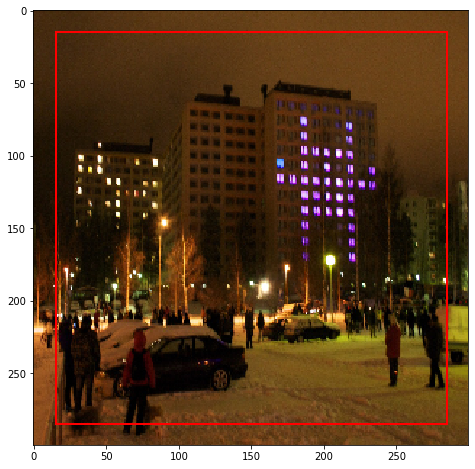

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        [cx, cy, w, h]
        
        visuals.draw_bbox(img, ref, color="#ff0000")
tt

1

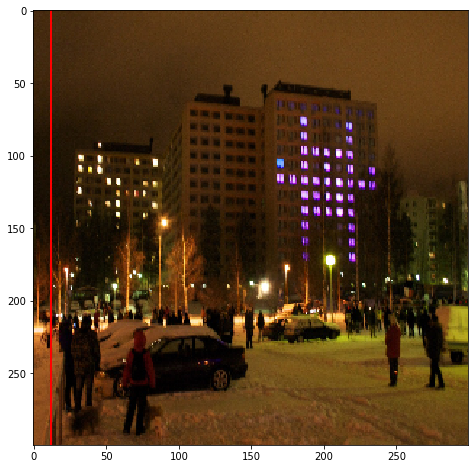

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        
        
        visuals.draw_bbox(img, [cx, cy, w, h], color="#ff0000")
tt

In [17]:
h

2.243039